In [1]:
from pandas import CategoricalDtype, read_csv
import pandas as pd

# -------------------------
# 1. 설정 정의
# -------------------------

# CSV key 목록
RE_KEYS = ('DE', 'DR', 'V')

# 기본 숫자 변환기
parse_int = lambda x: int(x) if x else 0
parse_int_comma = lambda x: int(x.replace(',', '')) if x else 0

# CSV 컬럼별 변환 함수
CONVERTERS = {
    'T': lambda x: int(x) if x else 1,
    'R': lambda x: x if x else 'A',
    'E': parse_int,
    'A': parse_int,
    'DE': parse_int,
    'DA': parse_int_comma,
    'H': parse_int_comma,
    'M': parse_int_comma,
}

# 컬럼별 dtype
DTYPES = {
    'T': CategoricalDtype((1, 2)),
    'R': CategoricalDtype(('A', 'T', 'D', 'S')),
    'E': 'uint8',
    'A': 'uint8',
    'DE': 'uint8',
    'DA': 'uint16',
    'H': 'uint16',
    'M': 'uint16'
}


# -------------------------
# 2. CSV 데이터 읽기 & 병합
# -------------------------

def load_re_data():
    df_list = []
    for key in RE_KEYS:
        df = read_csv(f'R/{key}.csv', index_col=0, converters=CONVERTERS)
        df = df.astype(DTYPES, copy=False)
        df_list.append(df)
    return pd.concat(df_list, keys=RE_KEYS, names=('RE',))


df = load_re_data()
df

T  R   E  A  DE    DA     H     M
RE I                                     
DE 1    1  T   0  0   8  2947  1425  4611
   1    1  D   1  0   3  1818     0   650
   1    1  D   2  0   7  4735   487   308
   1    1  S   1  0   3  2078  2748     0
   1    1  S   1  1   3   269  5848   189
...    .. ..  .. ..  ..   ...   ...   ...
V  467  2  T   7  2   4  6453     0  9665
   467  2  D  10  0   5  6272    62  1417
   467  2  D   6  1   7  5267    78    76
   467  2  S   5  1   6  4602  8211   716
   467  2  S   2  5   7  1979  7396   329

[9110 rows x 8 columns]

In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 9110 entries, ('DE', np.int64(1)) to ('V', np.int64(467))
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype   
---  ------  --------------  -----   
 0   T       9110 non-null   category
 1   R       9110 non-null   category
 2   E       9110 non-null   uint8   
 3   A       9110 non-null   uint8   
 4   DE      9110 non-null   uint8   
 5   DA      9110 non-null   uint16  
 6   H       9110 non-null   uint16  
 7   M       9110 non-null   uint16  
dtypes: category(2), uint16(3), uint8(3)
memory usage: 144.9+ KB


In [3]:
# -------------------------
# 3. 첫 2개 컬럼은 범주형 → 코드화
#    나머지 숫자 컬럼은 자리수별로 분해
# -------------------------

cols = df.columns.to_list()
category_cols = cols[:2]
numeric_cols = cols[2:]
category_cols, numeric_cols

(['T', 'R'], ['E', 'A', 'DE', 'DA', 'H', 'M'])

In [4]:
from pandas import DataFrame
from math import floor, log10

# 최종 변환 테이블
encoded = DataFrame({col: df[col].cat.codes.to_numpy('uint8') for col in category_cols})

for col in numeric_cols:
    max_value = df[col].max()
    max_digit = floor(log10(max_value)) if max_value > 0 else 0
    for pos in range(max_digit, -1, -1):
        encoded[f'{col}{pos}'] = (df[col].to_numpy() // 10 ** pos % 10).astype('uint8', copy=False)

encoded

,T,R,E1,E0,A1,A0,DE1,DE0,DA4,DA3,...,H4,H3,H2,H1,H0,M4,M3,M2,M1,M0
0,0,1,0,0,0,0,0,8,0,2,...,0,1,4,2,5,0,4,6,1,1
1,0,2,0,1,0,0,0,3,0,1,...,0,0,0,0,0,0,0,6,5,0
2,0,2,0,2,0,0,0,7,0,4,...,0,0,4,8,7,0,0,3,0,8
3,0,3,0,1,0,0,0,3,0,2,...,0,2,7,4,8,0,0,0,0,0
4,0,3,0,1,0,1,0,3,0,0,...,0,5,8,4,8,0,0,1,8,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9105,1,1,0,7,0,2,0,4,0,6,...,0,0,0,0,0,0,9,6,6,5
9106,1,2,1,0,0,0,0,5,0,6,...,0,0,0,6,2,0,1,4,1,7
9107,1,2,0,6,0,1,0,7,0,5,...,0,0,0,7,8,0,0,0,7,6
9108,1,3,0,5,0,1,0,6,0,4,...,0,8,2,1,1,0,0,7,1,6


In [5]:
encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9110 entries, 0 to 9109
Data columns (total 23 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   T       9110 non-null   uint8
 1   R       9110 non-null   uint8
 2   E1      9110 non-null   uint8
 3   E0      9110 non-null   uint8
 4   A1      9110 non-null   uint8
 5   A0      9110 non-null   uint8
 6   DE1     9110 non-null   uint8
 7   DE0     9110 non-null   uint8
 8   DA4     9110 non-null   uint8
 9   DA3     9110 non-null   uint8
 10  DA2     9110 non-null   uint8
 11  DA1     9110 non-null   uint8
 12  DA0     9110 non-null   uint8
 13  H4      9110 non-null   uint8
 14  H3      9110 non-null   uint8
 15  H2      9110 non-null   uint8
 16  H1      9110 non-null   uint8
 17  H0      9110 non-null   uint8
 18  M4      9110 non-null   uint8
 19  M3      9110 non-null   uint8
 20  M2      9110 non-null   uint8
 21  M1      9110 non-null   uint8
 22  M0      9110 non-null   uint8
dtypes: uint8(23)


In [6]:
# 전체 열을 10단위 길이 벡터로 변환
reshaped = tuple(encoded.to_numpy().reshape(-1, encoded.shape[-1] * 10).T)
len(reshaped)

230

2025-11-29 09:53:54.685500: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1764410034.703543     575 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1764410034.709197     575 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1764410034.726386     575 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1764410034.726404     575 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1764410034.726406     575 computation_placer.cc:177] computation placer alr

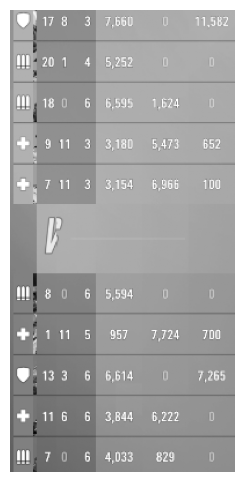

0 1 1 7 0 8 0 3 0 7 6 6 0 0 0 0 0 0 1 1 5 8 2 0 2 2 0 0 1 0 4 0 5 2 5 2 0 0 0 0 0 0 0 0 0 0 0 2 1 8 0 0 0 6 0 6 5 9 5 0 1 6 2 4 0 0 0 0 0 0 3 0 9 1 1 0 3 0 3 1 8 0 0 5 4 7 3 0 0 6 5 2 0 3 0 7 1 1 0 3 0 3 1 5 4 0 6 9 6 6 0 0 1 0 0 1 2 0 8 0 0 0 6 0 5 5 9 4 0 0 0 0 0 0 0 0 0 0 1 3 0 1 1 1 0 5 0 0 9 5 7 0 7 7 2 4 0 0 7 0 0 1 1 1 3 0 3 0 6 0 6 6 1 4 0 0 0 0 0 0 7 2 6 5 1 3 1 1 0 6 0 6 0 3 8 4 4 0 6 2 2 2 0 0 0 0 0 1 2 0 7 0 0 0 6 0 4 0 3 3 0 0 8 2 9 0 0 0 0 0


2025-11-29 09:54:01.392148: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [7]:
from pathlib import Path
from tensorflow.random import shuffle
import tensorflow as tf
from tensorflow import gather
from tensorflow.data import Dataset, AUTOTUNE
from tensorflow.image import decode_png, resize
from tensorflow.io import read_file
from matplotlib.pyplot import figure, axis, imshow, show

image_paths = sorted(map(str, Path().rglob('*.png')))

data_count = len(image_paths)
indices = shuffle(tf.range(data_count))
X_shuffled = gather(image_paths, indices)
y_shuffled = tuple(gather(head, indices) for head in reshaped)

train_size = int(data_count * .9)
train_X = X_shuffled[:train_size]
val_X = X_shuffled[train_size:]

train_y = tuple(head[:train_size] for head in y_shuffled)
val_y = tuple(head[train_size:] for head in y_shuffled)


def preprocess_image(path, label):
    """PNG 이미지 파일을 읽고 필요한 부분을 추출 및 리사이즈."""
    image = decode_png(read_file(path), channels=1)[230:930, 530:1370]
    # 필요한 HUD 영역만 선택
    hud_parts = [
        image[:, :40], image[:, 390:420], image[:, 450:480],
        image[:, 500:530], image[:, 570:640], image[:, 670:740], image[:, 770:]
    ]
    cropped = tf.concat(hud_parts, axis=1)
    resized = resize(cropped, (400, 194)) / 255
    return resized, label


def make_dataset(X, y, shuffle=False, batch_size=32):
    ds = Dataset.from_tensor_slices((X, y))
    ds = ds.map(preprocess_image, num_parallel_calls=AUTOTUNE)  # 이미지 전처리
    ds = ds.batch(batch_size).prefetch(AUTOTUNE)
    return ds


train_ds = make_dataset(train_X, train_y, shuffle=True)
val_ds = make_dataset(val_X, val_y, shuffle=False)
for x_batch, y_batch in train_ds.take(1):
    figure(figsize=(6, 6))
    axis('off')
    imshow(x_batch[0], 'gray')
    show()
    print(*[tensor[0].numpy() for tensor in y_batch], sep=' ')

In [13]:
from tensorflow.keras.backend import clear_session
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Conv2D, BatchNormalization, ReLU, MaxPool2D, SpatialDropout2D, Flatten, Dropout, Dense
from tensorflow.keras.losses import BinaryCrossentropy, SparseCategoricalCrossentropy

clear_session()

input_tensor = Input(shape=x_batch.shape[1:])  # (400, 194, 1)

x = Conv2D(32, 3, padding='same', use_bias=False)(input_tensor)
x = BatchNormalization()(x)
x = ReLU()(x)
x = MaxPool2D()(x)
x = SpatialDropout2D(0.1)(x)

x = Conv2D(64, 3, padding='same', use_bias=False)(x)
x = BatchNormalization()(x)
x = ReLU()(x)
x = MaxPool2D()(x)
x = SpatialDropout2D(0.1)(x)

x = Conv2D(128, 3, padding='same', use_bias=False)(x)
x = BatchNormalization()(x)
x = ReLU()(x)
x = MaxPool2D()(x)
x = SpatialDropout2D(0.15)(x)

x = Conv2D(256, 3, padding='same', use_bias=False)(x)
x = BatchNormalization()(x)
x = ReLU()(x)
x = MaxPool2D()(x)
x = SpatialDropout2D(0.2)(x)

x = Flatten()(x)
x = Dropout(0.4)(x)

x = Dense(256, use_bias=False)(x)
x = BatchNormalization()(x)
x = ReLU()(x)
x = Dropout(0.3)(x)

cols = encoded.nunique().to_dict()
outputs = []
for i in range(10):
    for col in cols:
        h = Dense(64, use_bias=False)(x)
        h = BatchNormalization()(h)
        h = ReLU()(h)
        h = Dropout(0.15)(h)
        if cols[col] <= 2:
            outputs.append(Dense(1, name=f'{col}_{i}')(h))
        else:
            outputs.append(Dense(cols[col], name=f'{col}_{i}')(h))
model = Model(inputs=input_tensor, outputs=outputs)

loss = {}
for i in range(10):
    for col in cols:
        if cols[col] <= 2:
            loss[f'{col}_{i}'] = BinaryCrossentropy(True)
        else:
            loss[f'{col}_{i}'] = SparseCategoricalCrossentropy(True)

metrics = {}
for i in range(10):
    for col in cols:
        metrics[f'{col}_{i}'] = 'accuracy'
model.compile('adamw', loss, metrics=metrics)

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 400, 194,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 400, 194,  │        288 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 400, 194,  │        128 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu (ReLU)        │ (None, 400, 194,  │          0 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 200, 97,   │          0 │ re_lu[0][0]       │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ spatial_dropout2d   │ (None, 200, 97,   │          0 │ max_pooling2d[0]… │
│ (SpatialDropout2D)  │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 200, 97,   │     18,432 │ spatial_dropout2… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 200, 97,   │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_1 (ReLU)      │ (None, 200, 97,   │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 100, 48,   │          0 │ re_lu_1[0][0]     │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ spatial_dropout2d_1 │ (None, 100, 48,   │          0 │ max_pooling2d_1[… │
│ (SpatialDropout2D)  │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 100, 48,   │     73,728 │ spatial_dropout2… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 100, 48,   │        512 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_2 (ReLU)      │ (None, 100, 48,   │          0 │ batch_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 50, 24,    │          0 │ re_lu_2[0][0]     │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ spatial_dropout2d_2 │ (None, 50, 24,    │          0 │ max_pooling2d_2[… │
│ (SpatialDropout2D)  │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 50, 24,    │    294,912 │ spatial_dropout2

 Total params: 23,995,954 (91.54 MB)

 Trainable params: 23,965,042 (91.42 MB)

 Non-trainable params: 30,912 (120.75 KB)

In [14]:
from tensorflow.keras.callbacks import Callback, EarlyStopping


class MetricSummaryCallback(Callback):
    def __init__(self, metric_groups=numeric_cols):
        super().__init__()
        self.metric_groups = metric_groups

    def on_train_begin(self, logs=None):
        self.total_epochs = self.params.get('epochs', None)

    def on_epoch_end(self, epoch, logs=None):
        epoch_num = epoch + 1
        total_epochs = self.total_epochs or '?'
        print(f'{epoch_num}/{total_epochs}')

        for group in self.metric_groups:
            train_logs = {
                key: value for key, value in logs.items()
                if key.startswith(group)
            }

            train_loss_values = [
                v for k, v in train_logs.items() if k.endswith('_loss')
            ]
            train_avg_loss = sum(train_loss_values) / len(train_loss_values) if train_loss_values else None
            
            train_metric_values = [
                v for k, v in train_logs.items() if k.endswith('_accuracy')
            ]
            train_avg_metric = sum(train_metric_values) / len(train_metric_values) if train_metric_values else None

            val_logs = {
                key: value for key, value in logs.items()
                if key.startswith(f'val_{group}')
            }

            val_loss_values = [
                v for k, v in val_logs.items() if k.endswith('_loss')
            ]
            val_avg_loss = sum(val_loss_values) / len(val_loss_values) if val_loss_values else None
            
            val_metric_values = [
                v for k, v in val_logs.items() if k.endswith('_accuracy')
            ]
            val_avg_metric = sum(val_metric_values) / len(val_metric_values) if val_metric_values else None

            print(
                f'- {group} '
                f'- loss: {train_avg_loss:.4f} '
                f'- accuracy: {train_avg_metric:.4f} '
                f'- val_loss: {val_avg_loss:.4f} '
                f'- val_accuracy: {val_avg_metric:.4f} '
            )


# EarlyStopping 콜백 설정
early_stop = EarlyStopping(patience=8, verbose=1, restore_best_weights=True)

# 학습
history = model.fit(
    train_ds,
    epochs=256,
    verbose=0,
    callbacks=(MetricSummaryCallback(), early_stop),
    validation_data=val_ds
)

I0000 00:00:1764413610.777359     630 service.cc:152] XLA service 0x782d1c47dd60 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1764413610.777437     630 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 3070 Ti, Compute Capability 8.6
2025-11-29 10:53:36.334704: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1764413634.882695     630 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1764413870.935035     630 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
2025-11-29 11:03:20.379218: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_238', 4 bytes spill stores, 4 bytes spill loads



1/256
- E - loss: 2.2648 - accuracy: 0.1735 - val_loss: 1.9728 - val_accuracy: 0.2098 
- A - loss: 2.1443 - accuracy: 0.2493 - val_loss: 1.9046 - val_accuracy: 0.4190 
- DE - loss: 1.8437 - accuracy: 0.3096 - val_loss: 1.5641 - val_accuracy: 0.4582 
- DA - loss: 2.2929 - accuracy: 0.1833 - val_loss: 2.0114 - val_accuracy: 0.2452 
- H - loss: 2.1495 - accuracy: 0.2484 - val_loss: 1.8800 - val_accuracy: 0.4446 
- M - loss: 2.2435 - accuracy: 0.2121 - val_loss: 1.9034 - val_accuracy: 0.4598 
2/256
- E - loss: 1.9888 - accuracy: 0.2562 - val_loss: 1.8866 - val_accuracy: 0.2576 
- A - loss: 1.6989 - accuracy: 0.4350 - val_loss: 1.5990 - val_accuracy: 0.4652 
- DE - loss: 1.5819 - accuracy: 0.4275 - val_loss: 1.4686 - val_accuracy: 0.4533 
- DA - loss: 2.1050 - accuracy: 0.2350 - val_loss: 2.0047 - val_accuracy: 0.2450 
- H - loss: 1.7226 - accuracy: 0.4573 - val_loss: 1.6545 - val_accuracy: 0.5224 
- M - loss: 1.7689 - accuracy: 0.4456 - val_loss: 1.6125 - val_accuracy: 0.5570 
3/256
- E - 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


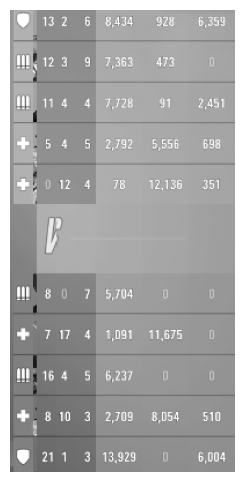

In [38]:
from numpy import array

for x_batch, y_batch in val_ds.take(1):
    x_sample = x_batch[0:1]
    y_sample = tuple(y[0] for y in y_batch)
    y_pred = model.predict(x_sample)
    figure(figsize=(6, 6))
    axis('off')
    imshow(x_batch[0], 'gray')
    show()

In [40]:
print(*[tensor[0].numpy() for tensor in y_batch])
print()
print(*[int(y.argmax()) for y in y_pred])

0 1 1 3 0 2 0 6 0 8 4 3 4 0 0 9 2 8 0 6 3 5 9 0 2 1 2 0 3 0 9 0 7 3 6 3 0 0 4 7 3 0 0 0 0 0 0 2 1 1 0 4 0 4 0 7 7 2 8 0 0 0 9 1 0 2 4 5 1 0 3 0 5 0 4 0 5 0 2 7 9 2 0 5 5 5 6 0 0 6 9 8 0 3 0 0 1 2 0 4 0 0 0 7 8 1 2 1 3 6 0 0 3 5 1 1 2 0 8 0 0 0 7 0 5 7 0 4 0 0 0 0 0 0 0 0 0 0 1 3 0 7 1 7 0 4 0 1 0 9 1 1 1 6 7 5 0 0 0 0 0 1 2 1 6 0 4 0 5 0 6 2 3 7 0 0 0 0 0 0 0 0 0 0 1 3 0 8 1 0 0 3 0 2 7 0 9 0 8 0 5 4 0 0 5 1 0 1 1 2 1 0 1 0 3 1 3 9 2 9 0 0 0 0 0 0 6 0 0 4

0 1 1 3 0 3 0 0 0 6 1 1 3 0 0 0 0 0 0 4 6 8 8 0 2 0 4 0 1 0 1 0 4 5 7 6 0 0 0 0 0 0 0 0 0 0 0 2 0 8 0 0 0 8 0 4 6 6 7 0 0 0 0 0 0 0 0 0 0 0 3 0 0 0 1 0 1 0 0 3 6 0 0 0 0 7 0 0 0 0 0 0 0 3 0 0 0 0 0 4 0 1 0 4 2 0 6 7 6 1 0 0 0 0 0 0 2 0 0 0 0 0 0 0 4 2 5 6 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 4 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 4 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 0 0 0 0 0 0 0 0 0 5 0 0 0 0 0 0 0 0 0 0 0 0 3 0 0 0 0 0 0 0 0 0 0 5 0 0 0 0 0 0 0 0 0 0
